1) EDA & Stratified Splits (70/15/15)

Mounted at /content/drive
Metadata: (8432, 7)
                                            zip_path  \
0  /content/drive/MyDrive/Agriculture_Dataset/Tam...   
1  /content/drive/MyDrive/Agriculture_Dataset/Tam...   
2  /content/drive/MyDrive/Agriculture_Dataset/Tam...   
3  /content/drive/MyDrive/Agriculture_Dataset/Tam...   
4  /content/drive/MyDrive/Agriculture_Dataset/Tam...   

                                          zip_member  \
0  Tamarind Image Dataset Healthy and Unhealthy C...   
1  Tamarind Image Dataset Healthy and Unhealthy C...   
2  Tamarind Image Dataset Healthy and Unhealthy C...   
3  Tamarind Image Dataset Healthy and Unhealthy C...   
4  Tamarind Image Dataset Healthy and Unhealthy C...   

                                                path    label   domain  \
0  zip:///content/drive/MyDrive/Agriculture_Datas...  Unknown  Unknown   
1  zip:///content/drive/MyDrive/Agriculture_Datas...  Unknown  Unknown   
2  zip:///content/drive/MyDrive/Agriculture_Datas...  Unkn

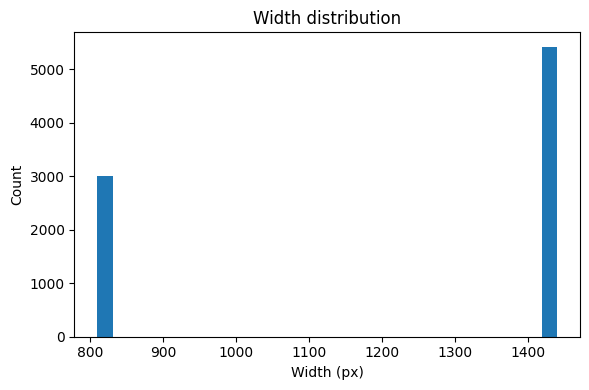

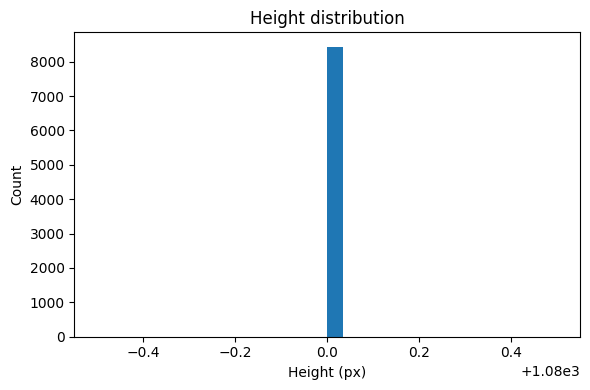


Computing perceptual hashes for duplicate detection (may take time)...
Duplicate groups (size>1): 323

Class distribution:
         count  percent
label                  
Unknown   8432    100.0
train: 5902
val: 1264
test: 1266

=== train summary ===
Label distribution:
 label
Unknown    1.0
Name: proportion, dtype: float64
Domain distribution:
 domain
Unknown    1.0
Name: proportion, dtype: float64
Label x Domain:
 domain   Unknown
label           
Unknown      1.0

=== val summary ===
Label distribution:
 label
Unknown    1.0
Name: proportion, dtype: float64
Domain distribution:
 domain
Unknown    1.0
Name: proportion, dtype: float64
Label x Domain:
 domain   Unknown
label           
Unknown      1.0

=== test summary ===
Label distribution:
 label
Unknown    1.0
Name: proportion, dtype: float64
Domain distribution:
 domain
Unknown    1.0
Name: proportion, dtype: float64
Label x Domain:
 domain   Unknown
label           
Unknown      1.0

Wrote:
 - metadata_raw.csv
 - resolutions.cs

In [ ]:
# 1_eda_and_splits_from_zip.ipynb / .py
# -------------------------------------------------
# EDA + stratified splits directly from a ZIP on Google Drive
# No unzip needed. Reads images inside the archive using zipfile.ZipFile.
# -------------------------------------------------

import os, sys, io, json, random, subprocess
from pathlib import Path
from collections import Counter
import zipfile

# Core deps
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Try installing ImageHash if missing (robust, works in Colab & plain Python)
def ensure_imagehash():
    try:
        import imagehash  # noqa: F401
        return True
    except ModuleNotFoundError:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "ImageHash"], stdout=subprocess.DEVNULL)
            import imagehash  # noqa: F401
            return True
        except Exception:
            return False

_HAS_IMAGEHASH = ensure_imagehash()

# Try to mount Google Drive if we're in Colab
def maybe_mount_drive():
    try:
        import google.colab  # type: ignore
        from google.colab import drive  # type: ignore
        # Only mount if not already mounted
        if not Path("/content/drive").exists() or not any(Path("/content/drive").iterdir()):
            drive.mount('/content/drive', force_remount=False)
        return True
    except Exception:
        return False

_IN_COLAB = maybe_mount_drive()

# -------------------
# CONFIG
# -------------------
# CHANGE THIS to your actual ZIP in Drive or local filesystem:
DATA_ZIP = Path("/content/drive/MyDrive/Agriculture_Dataset/Tamarind Image Dataset Healthy and Unhealthy Categories.zip")  # e.g., /content/drive/MyDrive/.../tamarind.zip

OUT_DIR  = Path("work_tamarind")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# -------------------
# SAFETY CHECKS
# -------------------
if not DATA_ZIP.exists():
    raise FileNotFoundError(
        f"ZIP not found: {DATA_ZIP}\n"
        "Please set DATA_ZIP to your actual path (e.g., '/content/drive/MyDrive/.../tamarind.zip')."
    )

# -------------------
# HASH HELPERS
# -------------------
def phash_from_pil_im(im: Image.Image) -> str:
    """
    Return a perceptual hash hex string.
    Uses imagehash.phash if available, otherwise falls back to a simple aHash (8x8).
    """
    try:
        if _HAS_IMAGEHASH:
            import imagehash
            return str(imagehash.phash(im.convert("RGB")))
    except Exception:
        pass  # fall back to aHash below

    # Fallback: average-hash (aHash) 8x8 -> 64 bits -> 16 hex chars
    im_small = im.convert("L").resize((8, 8))
    arr = np.asarray(im_small, dtype=np.float32)
    avg = arr.mean()
    bits = (arr > avg).astype(np.uint8).flatten()
    out = 0
    for b in bits:
        out = (out << 1) | int(b)
    return f"{out:016x}"

# -------------------
# ZIP HELPERS
# -------------------
def is_image_name(name: str) -> bool:
    return Path(name).suffix.lower() in VALID_EXTS

def normalize_zip_path(name: str) -> str:
    p = name.replace("\\", "/")
    if p.startswith("./"):
        p = p[2:]
    return p

def infer_label_domain_from_parts(parts):
    """
    Expected: .../<Healthy|Unhealthy>/<Shelled|Unshelled|Mixed>/image.ext
    Returns ('Healthy'|'Unhealthy'|'Unknown', 'Shelled'|'Unshelled'|'Mixed'|'Unknown')
    """
    label = "Unknown"
    domain = "Unknown"
    for p in parts:
        low = p.lower()
        if low in ["healthy", "unhealthy"]:
            label = "Healthy" if low == "healthy" else "Unhealthy"
        if low in ["shelled", "unshelled", "mixed"]:
            domain = {"shelled":"Shelled", "unshelled":"Unshelled", "mixed":"Mixed"}[low]
    return label, domain

def zip_image_members(zf: zipfile.ZipFile):
    for name in zf.namelist():
        if not name or name.endswith("/"):
            continue
        nm = normalize_zip_path(name)
        if is_image_name(nm):
            yield nm

def open_image_from_zip(zippath: Path, member: str) -> Image.Image:
    with zipfile.ZipFile(zippath, "r") as zf:
        with zf.open(member, "r") as f:
            data = f.read()
    im = Image.open(io.BytesIO(data))
    im.load()
    return im

# -------------------
# STEP 1: Build metadata table
# -------------------
rows = []
with zipfile.ZipFile(DATA_ZIP, "r") as zf:
    all_img_members = list(zip_image_members(zf))
    if len(all_img_members) == 0:
        raise RuntimeError(
            f"No images found in ZIP: {DATA_ZIP}\n"
            f"Accepted extensions: {sorted(VALID_EXTS)}"
        )
    for member in all_img_members:
        parts = [p for p in member.split("/") if p]
        label, domain = infer_label_domain_from_parts(parts)
        rows.append({
            "zip_path": str(DATA_ZIP.as_posix()),
            "zip_member": member,
            "path": f"zip://{DATA_ZIP.as_posix()}::{member}",  # virtual path for convenience
            "label": label,
            "domain": domain,
        })

df = pd.DataFrame(rows).drop_duplicates(subset=["zip_member"]).reset_index(drop=True)
df["label_id"]  = df["label"].map({"Healthy":0, "Unhealthy":1})
df["domain_id"] = df["domain"].map({"Shelled":0, "Unshelled":1, "Mixed":2})

df.to_csv(OUT_DIR/"metadata_raw.csv", index=False)
print("Metadata:", df.shape)
print(df.head())

# -------------------
# STEP 2: Basic counts
# -------------------
from collections import Counter
print("\n=== Overall counts ===")
print("Total images:", len(df))
print("Classes:", Counter(df["label"]))
print("Domains:", Counter(df["domain"]))

ct = pd.crosstab(df["label"], df["domain"])
print("\nClass x Domain\n", ct)

# -------------------
# STEP 3: Image resolution variety + invalids
# -------------------
def get_size_from_zip(member: str):
    try:
        with zipfile.ZipFile(DATA_ZIP, "r") as zf:
            with zf.open(member, "r") as f:
                with Image.open(io.BytesIO(f.read())) as im:
                    im.load()
                    return im.size  # (W, H)
    except Exception:
        return None

print("\nReading image sizes (may take a while on large ZIPs)...")
df["size"] = df["zip_member"].apply(get_size_from_zip)
invalid = df["size"].isna().sum()
print(f"Invalid images (cannot open): {invalid}")

df_valid = df.dropna(subset=["size"]).copy()
if len(df_valid) == 0:
    raise RuntimeError("All images failed to open—please check the ZIP integrity or formats.")

df_valid["W"] = df_valid["size"].apply(lambda s: s[0])
df_valid["H"] = df_valid["size"].apply(lambda s: s[1])

res_counts = (
    df_valid.groupby(["W","H"])
    .size().reset_index(name="count")
    .sort_values("count", ascending=False)
)
res_counts.to_csv(OUT_DIR/"resolutions.csv", index=False)
print("\nTop resolutions:\n", res_counts.head(10))

# Plots (safe to skip if running headless)
try:
    plt.figure(figsize=(6,4))
    plt.hist(df_valid["W"], bins=30)
    plt.title("Width distribution")
    plt.xlabel("Width (px)"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(df_valid["H"], bins=30)
    plt.title("Height distribution")
    plt.xlabel("Height (px)"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
except Exception as _e:
    print("Plotting skipped (no display backend).")

# -------------------
# STEP 4: Duplicate groups via perceptual hashing
# -------------------
print("\nComputing perceptual hashes for duplicate detection (may take time)...")

def phash_from_zip(member: str) -> str | None:
    try:
        with zipfile.ZipFile(DATA_ZIP, "r") as zf:
            with zf.open(member, "r") as f:
                with Image.open(io.BytesIO(f.read())) as im:
                    return phash_from_pil_im(im)
    except Exception:
        return None

df_valid["phash"] = df_valid["zip_member"].apply(phash_from_zip)

dup_groups = (
    df_valid.dropna(subset=["phash"])
            .groupby("phash")["zip_member"]
            .apply(list).reset_index()
)
dup_groups = dup_groups[dup_groups["zip_member"].apply(lambda L: len(L) > 1)]

dup_groups_out = [
    {"phash": row["phash"], "members": row["zip_member"]}
    for _, row in dup_groups.iterrows()
]
with open(OUT_DIR/"duplicate_groups.json", "w") as f:
    json.dump(dup_groups_out, f, indent=2)

print(f"Duplicate groups (size>1): {len(dup_groups)}")

# -------------------
# STEP 5: Class imbalance quick view
# -------------------
class_counts = df_valid["label"].value_counts(dropna=False)
class_pct = (class_counts / class_counts.sum() * 100).round(2)
print("\nClass distribution:")
print(pd.DataFrame({"count": class_counts, "percent": class_pct}))

# -------------------
# STEP 6: Stratified 70/15/15 splits (by label+domain)
# -------------------
df_valid["strat_key"] = df_valid["label"].astype(str) + "_" + df_valid["domain"].astype(str)

# Validate stratification keys have at least 2 classes; otherwise, just do a simple split
unique_keys = df_valid["strat_key"].nunique()
use_stratified = unique_keys > 1 and df_valid["strat_key"].value_counts().min() >= 3  # enough samples per key

from sklearn.model_selection import StratifiedShuffleSplit

if use_stratified:
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_SEED)
    train_idx, temp_idx = next(sss1.split(df_valid, df_valid["strat_key"]))
    train_df = df_valid.iloc[train_idx].copy()
    temp_df  = df_valid.iloc[temp_idx].copy()

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_SEED)
    val_idx, test_idx = next(sss2.split(temp_df, temp_df["strat_key"]))
    val_df  = temp_df.iloc[val_idx].copy()
    test_df = temp_df.iloc[test_idx].copy()
else:
    # Fallback: non-stratified deterministic splits (small/degenerate cases)
    n = len(df_valid)
    idx = np.random.RandomState(RANDOM_SEED).permutation(n)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    train_df = df_valid.iloc[idx[:n_train]].copy()
    val_df   = df_valid.iloc[idx[n_train:n_train+n_val]].copy()
    test_df  = df_valid.iloc[idx[n_train+n_val:]].copy()

def save_split(name, d):
    cols_order = ["zip_path", "zip_member", "path", "label", "label_id", "domain", "domain_id"]
    cols_order = [c for c in cols_order if c in d.columns]
    d_out = d[cols_order].copy()
    d_out.to_csv(OUT_DIR/f"{name}.csv", index=False)
    print(f"{name}: {len(d_out)}")

save_split("train", train_df)
save_split("val",   val_df)
save_split("test",  test_df)

def split_summary(name, d):
    print(f"\n=== {name} summary ===")
    try:
        print("Label distribution:\n", d["label"].value_counts(normalize=True).round(4))
        print("Domain distribution:\n", d["domain"].value_counts(normalize=True).round(4))
        print("Label x Domain:\n", pd.crosstab(d["label"], d["domain"], normalize='all').round(4))
    except Exception as _e:
        print("Summary skipped due to insufficient categories.")

split_summary("train", train_df)
split_summary("val",   val_df)
split_summary("test",  test_df)

print("\nWrote:")
print(" - metadata_raw.csv")
print(" - resolutions.csv")
print(" - duplicate_groups.json")
print(" - train.csv, val.csv, test.csv")
print(f"\n(All in: {OUT_DIR.resolve()})")


Teacher Training: Swin-T + FiLM Domain Adapter + Simple MIL

This version treats each image as a bag of fixed patches (grid). We extract patch features with Swin-T, then apply FiLM (gamma/beta from domain embedding), then attention-based MIL pooling to get a bag-level prediction. Includes optional domain contrastive loss.

In [ ]:
# 2_teacher_swin_film_mil_train.ipynb / .py

import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import classification_report, f1_score, accuracy_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_SPLIT_DIR = Path("work_tamarind")
BATCH_SIZE = 8
EPOCHS = 20
LR = 2e-4
NUM_CLASSES = 2
DOMAINS = ["Shelled","Unshelled","Mixed"]
DOMAIN2ID = {d:i for i,d in enumerate(DOMAINS)}
IMG_SIZE = 384
GRID = (3, 3)  # 3x3 patches per image for MIL
TEMPERATURE_CL = 0.07  # for contrastive domain loss (optional)
USE_DOMAIN_CONTRASTIVE = True

# -------------------------
# Dataset
# -------------------------
class TamarindPatches(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment
        self.tfm_train = A.Compose([
            A.LongestMaxSize(IMG_SIZE),
            A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
            A.Flip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            ToTensorV2()
        ])
        self.tfm_eval  = A.Compose([
            A.LongestMaxSize(IMG_SIZE),
            A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
            ToTensorV2()
        ])

    def __len__(self): return len(self.df)

    def _grid_crops(self, img_tensor):
        # img_tensor: C,H,W
        C, H, W = img_tensor.shape
        gh, gw = GRID
        ph, pw = H // gh, W // gw
        patches = []
        for i in range(gh):
            for j in range(gw):
                patches.append(img_tensor[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw])
        return torch.stack(patches, dim=0)  # [P, C, ph, pw]

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        p = r["path"]
        y = 0 if r["label"] == "Healthy" else 1
        d = DOMAIN2ID.get(r["domain"], 0)

        with Image.open(p) as im:
            im = im.convert("RGB")
            arr = np.array(im)

        tfm = self.tfm_train if self.augment else self.tfm_eval
        out = tfm(image=arr)["image"]  # tensor C,H,W
        patches = self._grid_crops(out)
        return patches, torch.tensor(y).long(), torch.tensor(d).long(), p

# -------------------------
# FiLM Adapter + MIL Pool
# -------------------------
class FiLM(nn.Module):
    def __init__(self, feat_dim, num_domains=3):
        super().__init__()
        self.emb = nn.Embedding(num_domains, 128)
        self.to_gamma = nn.Linear(128, feat_dim)
        self.to_beta  = nn.Linear(128, feat_dim)

    def forward(self, x, d):
        # x: [B, P, D]
        e = self.emb(d)                 # [B, 128]
        gamma = self.to_gamma(e).unsqueeze(1)  # [B,1,D]
        beta  = self.to_beta(e).unsqueeze(1)   # [B,1,D]
        return x * (1 + gamma) + beta

class AttnMILPool(nn.Module):
    def __init__(self, in_dim, hidden=256):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, feats):
        # feats: [B, P, D]
        a = self.attn(feats)                        # [B,P,1]
        w = torch.softmax(a, dim=1)                 # [B,P,1]
        bag = (w * feats).sum(dim=1)                # [B,D]
        return bag, w

class TeacherNet(nn.Module):
    def __init__(self, backbone_name="swin_tiny_patch4_window7_224", num_domains=3, num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        self.feat_dim = self.backbone.num_features
        self.film = FiLM(self.feat_dim, num_domains=num_domains)
        self.mil  = AttnMILPool(self.feat_dim)
        self.head = nn.Linear(self.feat_dim, num_classes)

    @torch.no_grad()
    def encode_patch(self, x):  # x: [B*P, C, H, W]
        return self.backbone(x) # [B*P, D]

    def forward(self, patches, domain_ids):
        # patches: [B, P, C, h, w]
        B, P, C, h, w = patches.shape
        x = patches.view(B*P, C, h, w)
        patch_feats = self.backbone(x)          # [B*P, D]
        patch_feats = patch_feats.view(B, P, -1)  # [B,P,D]
        film_feats  = self.film(patch_feats, domain_ids)  # [B,P,D]
        bag, attn_w = self.mil(film_feats)     # [B,D], [B,P,1]
        logits = self.head(bag)                # [B,2]
        return logits, bag, film_feats, attn_w

# -------------------------
# Losses
# -------------------------
ce = nn.CrossEntropyLoss()

def domain_contrastive_loss(bag_feats, domain_ids, temp=TEMPERATURE_CL):
    """
    Simple supervised contrastive: pull same-domain bags together, push different apart.
    bag_feats: [B, D] (L2-normalized)
    domain_ids: [B]
    """
    z = nn.functional.normalize(bag_feats, dim=1)
    sim = torch.matmul(z, z.T) / temp  # [B,B]
    mask = (domain_ids.unsqueeze(1) == domain_ids.unsqueeze(0)).float()
    logits = sim - torch.eye(sim.size(0), device=sim.device) * 1e9  # remove self
    # log_softmax over rows
    logp = logits.log_softmax(dim=1)
    # average log prob of positives
    pos = logp * mask
    denom = mask.sum(dim=1).clamp_min(1.0)
    loss = -(pos.sum(dim=1) / denom).mean()
    return loss

# -------------------------
# Train / Val Loop
# -------------------------
def run_train(train_csv, val_csv, save_path="teacher_swin_film_mil.pt"):
    train_ds = TamarindPatches(train_csv, augment=True)
    val_ds   = TamarindPatches(val_csv,   augment=False)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = TeacherNet(num_domains=len(DOMAINS), num_classes=NUM_CLASSES).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    best_f1 = 0.0
    for epoch in range(1, EPOCHS+1):
        model.train()
        tr_loss = 0.0
        for patches, y, d, _ in train_dl:
            patches = patches.to(DEVICE)  # [B,P,C,h,w]
            y = y.to(DEVICE)
            d = d.to(DEVICE)

            logits, bag, film_feats, _ = model(patches, d)
            loss = ce(logits, y)
            if USE_DOMAIN_CONTRASTIVE:
                loss += 0.05 * domain_contrastive_loss(bag, d)

            opt.zero_grad()
            loss.backward()
            opt.step()
            tr_loss += loss.item() * patches.size(0)

        # validation
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for patches, y, d, _ in val_dl:
                patches = patches.to(DEVICE)
                y = y.to(DEVICE)
                d = d.to(DEVICE)
                logits, _, _, _ = model(patches, d)
                pred = logits.argmax(1)
                preds.extend(pred.cpu().tolist())
                gts.extend(y.cpu().tolist())

        acc = accuracy_score(gts, preds)
        mf1 = f1_score(gts, preds, average="macro")
        print(f"[Epoch {epoch}] train_loss={tr_loss/len(train_ds):.4f}  val_acc={acc:.4f}  val_macroF1={mf1:.4f}")

        if mf1 > best_f1:
            best_f1 = mf1
            torch.save(model.state_dict(), save_path)
            print(f"  -> saved {save_path} (best macro-F1 {best_f1:.4f})")

    return save_path

if __name__ == "__main__":
    best = run_train(DATA_SPLIT_DIR/"train.csv", DATA_SPLIT_DIR/"val.csv")
    print("Best model saved at:", best)


/tmp/ipython-input-1211754278.py:39: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),


AttributeError: module 'albumentations' has no attribute 'Flip'

3) Student Training with Knowledge Distillation (MobileNetV3 + KD)

We distill logits (soft targets, temperature τ) and features (MSE). Optionally a contrastive KD between teacher/student features.

In [ ]:
# 3_student_kd_mobilenetv3.ipynb / .py

import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import accuracy_score, f1_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_SPLIT_DIR = Path("work_tamarind")
BATCH_SIZE = 16
EPOCHS = 25
LR = 2e-4
NUM_CLASSES = 2
IMG_SIZE = 384
GRID = (3,3)
TAU = 3.0
ALPHA_LOGITS = 0.7   # KD weight for logits
BETA_FEAT   = 0.3    # KD weight for feature MSE
GAMMA_CTR   = 0.0    # set >0.0 to use contrastive KD on patch features

DOMAINS = ["Shelled","Unshelled","Mixed"]
DOMAIN2ID = {d:i for i,d in enumerate(DOMAINS)}

# -------- Dataset (same as teacher) --------
class TamarindPatches(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment
        self.tfm_train = A.Compose([
            A.LongestMaxSize(IMG_SIZE),
            A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
            A.Flip(p=0.5),
            A.ColorJitter(p=0.4),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            ToTensorV2()
        ])
        self.tfm_eval  = A.Compose([
            A.LongestMaxSize(IMG_SIZE),
            A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
            ToTensorV2()
        ])

    def __len__(self): return len(self.df)

    def _grid_crops(self, img_tensor):
        C, H, W = img_tensor.shape
        gh, gw = GRID
        ph, pw = H // gh, W // gw
        patches = []
        for i in range(gh):
            for j in range(gw):
                patches.append(img_tensor[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw])
        return torch.stack(patches, dim=0)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        p = r["path"]
        y = 0 if r["label"] == "Healthy" else 1
        d = DOMAIN2ID.get(r["domain"], 0)
        with Image.open(p) as im:
            im = im.convert("RGB")
            arr = np.array(im)
        tfm = self.tfm_train if self.augment else self.tfm_eval
        out = tfm(image=arr)["image"]
        patches = self._grid_crops(out)
        return patches, torch.tensor(y).long(), torch.tensor(d).long(), p

# -------- Models --------
class SimpleMIL(nn.Module):
    def __init__(self, in_dim, hidden=192):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, feats):
        a = self.attn(feats)               # [B,P,1]
        w = torch.softmax(a, dim=1)
        bag = (w * feats).sum(dim=1)       # [B,D]
        return bag, w

class StudentNet(nn.Module):
    def __init__(self, backbone="mobilenetv3_large_100", num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool="avg")
        self.feat_dim = self.backbone.num_features
        self.mil = SimpleMIL(self.feat_dim)
        self.head = nn.Linear(self.feat_dim, num_classes)

    def forward(self, patches):
        B,P,C,h,w = patches.shape
        x = patches.view(B*P, C, h, w)
        feats = self.backbone(x)           # [B*P, D]
        feats = feats.view(B,P,-1)
        bag, attn = self.mil(feats)
        logits = self.head(bag)
        return logits, bag, feats, attn

class TeacherWrapper(nn.Module):
    """Load the trained teacher for KD (frozen)."""
    def __init__(self, ckpt_path, num_domains=3, num_classes=2):
        super().__init__()
        from types import SimpleNamespace

        # Recreate TeacherNet structure from Part 2:
        import timm, torch.nn as nn
        class FiLM(nn.Module):
            def __init__(self, feat_dim, num_domains=3):
                super().__init__()
                self.emb = nn.Embedding(num_domains, 128)
                self.to_gamma = nn.Linear(128, feat_dim)
                self.to_beta  = nn.Linear(128, feat_dim)
            def forward(self, x, d):
                e = self.emb(d)
                gamma = self.to_gamma(e).unsqueeze(1)
                beta  = self.to_beta(e).unsqueeze(1)
                return x * (1 + gamma) + beta

        class AttnMILPool(nn.Module):
            def __init__(self, in_dim, hidden=256):
                super().__init__()
                self.attn = nn.Sequential(
                    nn.Linear(in_dim, hidden), nn.Tanh(),
                    nn.Linear(hidden, 1)
                )
            def forward(self, feats):
                a = self.attn(feats)
                w = torch.softmax(a, dim=1)
                bag = (w * feats).sum(dim=1)
                return bag, w

        class TeacherNet(nn.Module):
            def __init__(self, backbone_name="swin_tiny_patch4_window7_224", num_domains=3, num_classes=2):
                super().__init__()
                self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0, global_pool="avg")
                self.feat_dim = self.backbone.num_features
                self.film = FiLM(self.feat_dim, num_domains=num_domains)
                self.mil  = AttnMILPool(self.feat_dim)
                self.head = nn.Linear(self.feat_dim, num_classes)
            def forward(self, patches, domain_ids):
                B,P,C,h,w = patches.shape
                x = patches.view(B*P, C, h, w)
                pf = self.backbone(x).view(B,P,-1)
                ff = self.film(pf, domain_ids)
                bag, _ = self.mil(ff)
                logits = self.head(bag)
                return logits, bag, ff

        self.teacher = TeacherNet(num_domains=len(DOMAINS), num_classes=NUM_CLASSES)
        self.teacher.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
        self.teacher.eval()
        for p in self.teacher.parameters():
            p.requires_grad = False

    @torch.no_grad()
    def forward(self, patches, domain_ids):
        logits_t, bag_t, feats_t = self.teacher(patches, domain_ids)
        return logits_t, bag_t, feats_t

# -------- KD Losses --------
ce = nn.CrossEntropyLoss()
mse = nn.MSELoss()

def kd_logits_loss(student_logits, teacher_logits, T=TAU):
    # KLDiv between softened distributions
    log_p_s = nn.functional.log_softmax(student_logits / T, dim=1)
    p_t     = nn.functional.softmax(teacher_logits / T, dim=1)
    return nn.functional.kl_div(log_p_s, p_t, reduction="batchmean") * (T**2)

def contrastive_kd(student_feats, teacher_feats, temp=0.07):
    """
    Contrastive KD: align per-patch features from student to teacher for each image.
    student_feats, teacher_feats: [B,P,D]
    """
    B,P,D = student_feats.shape
    s = nn.functional.normalize(student_feats, dim=-1)
    t = nn.functional.normalize(teacher_feats, dim=-1)
    loss = 0.0
    for b in range(B):
        sim = s[b] @ t[b].T / temp  # [P,P]
        pos = torch.diag(sim)       # P positives
        denom = torch.logsumexp(sim, dim=1)
        loss += -(pos - denom).mean()
    return loss / B

# -------- Train --------
def run_train(train_csv, val_csv, teacher_ckpt, save_path="student_mnv3_kd.pt"):
    train_ds = TamarindPatches(train_csv, augment=True)
    val_ds   = TamarindPatches(val_csv,   augment=False)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    student = StudentNet(num_classes=NUM_CLASSES).to(DEVICE)
    teacher = TeacherWrapper(teacher_ckpt).to(DEVICE)
    opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=1e-4)

    best_f1 = 0.0
    for epoch in range(1, EPOCHS+1):
        student.train()
        tr_loss = 0.0
        for patches, y, d, _ in train_dl:
            patches = patches.to(DEVICE)
            y = y.to(DEVICE)
            d = d.to(DEVICE)

            # forward
            logits_s, bag_s, feats_s, _ = student(patches)
            with torch.no_grad():
                logits_t, bag_t, feats_t = teacher(patches, d)

            # losses
            loss_ce = ce(logits_s, y)
            loss_kd = kd_logits_loss(logits_s, logits_t, T=TAU)
            loss_fm = mse(bag_s, bag_t)

            loss = (1-ALPHA_LOGITS)*loss_ce + ALPHA_LOGITS*loss_kd + BETA_FEAT*loss_fm
            if GAMMA_CTR > 0:
                loss += GAMMA_CTR * contrastive_kd(feats_s, feats_t)

            opt.zero_grad()
            loss.backward()
            opt.step()
            tr_loss += loss.item() * patches.size(0)

        # validation
        student.eval()
        preds, gts = [], []
        with torch.no_grad():
            for patches, y, d, _ in val_dl:
                patches = patches.to(DEVICE)
                y = y.to(DEVICE)
                logits_s, _, _, _ = student(patches)
                preds.extend(torch.argmax(logits_s, 1).cpu().tolist())
                gts.extend(y.cpu().tolist())

        acc = accuracy_score(gts, preds)
        mf1 = f1_score(gts, preds, average="macro")
        print(f"[Epoch {epoch}] train_loss={tr_loss/len(train_ds):.4f}  val_acc={acc:.4f}  val_macroF1={mf1:.4f}")
        if mf1 > best_f1:
            best_f1 = mf1
            torch.save(student.state_dict(), save_path)
            print(f"  -> saved {save_path} (best macro-F1 {best_f1:.4f})")

    return save_path

if __name__ == "__main__":
    ckpt = "teacher_swin_film_mil.pt"  # from Part 2
    best = run_train(DATA_SPLIT_DIR/"train.csv", DATA_SPLIT_DIR/"val.csv", ckpt)
    print("Best student saved at:", best)


4) Evaluation + Cross-Domain Robustness

Train on all domains (as you did), then slice by domain on the test set and also run train-on-one, test-on-another (optional).

In [ ]:
# 4_evaluate_cross_domain.ipynb / .py

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_SPLIT_DIR = Path("work_tamarind")
TEST_CSV = DATA_SPLIT_DIR/"test.csv"
NUM_CLASSES = 2
IMG_SIZE = 384
GRID = (3,3)

DOMAINS = ["Shelled","Unshelled","Mixed"]
DOMAIN2ID = {d:i for i,d in enumerate(DOMAINS)}

class EvalDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.tfm = A.Compose([
            A.LongestMaxSize(IMG_SIZE),
            A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
            ToTensorV2()
        ])
    def __len__(self): return len(self.df)
    def _grid(self, t):
        C,H,W = t.shape
        gh, gw = GRID
        ph, pw = H//gh, W//gw
        patches = []
        for i in range(gh):
            for j in range(gw):
                patches.append(t[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw])
        return torch.stack(patches, 0)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        p = r["path"]
        y = 0 if r["label"]=="Healthy" else 1
        d = DOMAIN2ID.get(r["domain"], 0)
        with Image.open(p) as im:
            im = im.convert("RGB")
            arr = np.array(im)
        t = self.tfm(image=arr)["image"]
        patches = self._grid(t)
        return patches, torch.tensor(y).long(), torch.tensor(d).long(), r["domain"], p

class StudentNet(nn.Module):
    def __init__(self, backbone="mobilenetv3_large_100", num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=False, num_classes=0, global_pool="avg")
        self.feat_dim = self.backbone.num_features
        self.attn = nn.Sequential(nn.Linear(self.feat_dim, 192), nn.ReLU(), nn.Linear(192,1))
        self.head = nn.Linear(self.feat_dim, num_classes)
    def forward(self, patches):
        B,P,C,h,w = patches.shape
        x = patches.view(B*P, C, h, w)
        f = self.backbone(x).view(B,P,-1)
        a = torch.softmax(self.attn(f), dim=1)
        bag = (a*f).sum(dim=1)
        logits = self.head(bag)
        return logits

def evaluate(model_path, csv=TEST_CSV):
    ds = EvalDataset(csv)
    dl = DataLoader(ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
    model = StudentNet(num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    y_true, y_pred, domains = [], [], []
    with torch.no_grad():
        for patches, y, d, dom_str, _ in dl:
            patches = patches.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(patches)
            pred = logits.argmax(1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())
            domains.extend(dom_str)

    print("Overall:")
    print(classification_report(y_true, y_pred, target_names=["Healthy","Unhealthy"], digits=4))
    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    print(f"Acc={acc:.4f}  Macro-F1={mf1:.4f}")

    # Per-domain
    per = defaultdict(lambda: {"y":[],"p":[]})
    for yt, yp, dom in zip(y_true, y_pred, domains):
        per[dom]["y"].append(yt); per[dom]["p"].append(yp)
    print("\nPer-domain performance:")
    for dom in DOMAINS:
        if dom in per:
            y = per[dom]["y"]; p = per[dom]["p"]
            acc = accuracy_score(y,p)
            mf1 = f1_score(y,p,average="macro")
            pr, rc, f1, _ = precision_recall_fscore_support(y,p,average="binary", pos_label=1, zero_division=0)
            print(f"- {dom}: Acc={acc:.4f} Macro-F1={mf1:.4f}  (Unhealthy class) P={pr:.4f} R={rc:.4f} F1={f1:.4f}")

if __name__ == "__main__":
    evaluate("student_mnv3_kd.pt")


5) Explainability: Grad-CAM + (Optionally) Teacher Attention Maps

We apply Grad-CAM to the student’s final conv stage. If you want teacher attention visualizations, we also render MIL attention weights over the 3×3 patch grid.

In [ ]:
# 5_explainability.ipynb / .py

import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch
import torch.nn as nn
import timm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 384
GRID = (3,3)

class StudentForGradCAM(nn.Module):
    def __init__(self, backbone="mobilenetv3_large_100", num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=False, num_classes=0, global_pool="avg")
        self.feat_dim = self.backbone.num_features
        self.attn = nn.Sequential(nn.Linear(self.feat_dim, 192), nn.ReLU(), nn.Linear(192,1))
        self.head = nn.Linear(self.feat_dim, num_classes)
        # pick a conv layer for cam
        self.target_layer = None
        # try to find the last conv
        for m in reversed(list(self.backbone.modules())):
            if isinstance(m, nn.Conv2d):
                self.target_layer = m
                break

    def forward(self, patches):
        B,P,C,h,w = patches.shape
        x = patches.view(B*P, C, h, w)
        f = self.backbone(x)                   # [B*P, D]
        f = f.view(B,P,-1)
        a = torch.softmax(self.attn(f), dim=1) # [B,P,1]
        bag = (a*f).sum(dim=1)                 # [B,D]
        logits = self.head(bag)
        return logits, a

def preprocess_image(img_path):
    tfm = A.Compose([
        A.LongestMaxSize(IMG_SIZE),
        A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=0, value=(0,0,0)),
        ToTensorV2()
    ])
    with Image.open(img_path) as im:
        im = im.convert("RGB")
        arr = np.array(im)
    out = tfm(image=arr)["image"]  # C,H,W
    return arr, out

def grid_patches(t):
    C,H,W = t.shape
    gh,gw = GRID
    ph,pw = H//gh, W//gw
    patches = []
    for i in range(gh):
        for j in range(gw):
            patches.append(t[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw])
    return torch.stack(patches,0)  # [P,C,ph,pw]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.fmap = None
        self.grad = None
        target_layer.register_forward_hook(self.fwd_hook)
        target_layer.register_full_backward_hook(self.bwd_hook)
    def fwd_hook(self, module, inp, out):
        self.fmap = out.detach()
    def bwd_hook(self, module, grad_in, grad_out):
        self.grad = grad_out[0].detach()
    def __call__(self, inp, class_idx):
        # inp: [B*P, C, h, w] going through backbone only — BUT
        # our model pools after backbone. We'll do a forward and then backprop.
        self.model.zero_grad()
        logits, attn = self.model(inp.view(1, *inp.shape))  # hack: treat as [1,P,C,h,w]
        score = logits[0, class_idx]
        score.backward()
        # grad-cam over last conv feature map captured
        grads = self.grad       # [?, C, H, W]
        fmap  = self.fmap       # same shape
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * fmap).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam, attn

def overlay_cam_on_image(img_rgb, cam):
    cam_resized = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))
    heatmap = cv2.applyColorMap((cam_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = (0.4*heatmap + 0.6*img_rgb[:,:,::-1]).astype(np.uint8)  # BGR mix but final look ok
    return overlay[:, :, ::-1]  # back to RGB

if __name__ == "__main__":
    model = StudentForGradCAM(num_classes=2).to(DEVICE)
    model.load_state_dict(torch.load("student_mnv3_kd.pt", map_location=DEVICE))
    model.eval()

    # pick an image to visualize
    EXAMPLE_IMG = "path/to/one/test/image.jpg"  # <- set one path from test.csv
    orig, t = preprocess_image(EXAMPLE_IMG)     # orig: H,W,3  t: C,H,W
    patches = grid_patches(t).unsqueeze(0).to(DEVICE)  # [1,P,C,h,w]

    cam_engine = GradCAM(model, model.target_layer)
    # choose class index: 0 Healthy, 1 Unhealthy
    CAM_CLASS = 1

    with torch.no_grad():
        logits, attn = model(patches)
        pred = logits.argmax(1).item()
        print(f"Pred class: {pred} (0=Healthy,1=Unhealthy)")

    cam, attn_weights = cam_engine(patches.squeeze(0), CAM_CLASS)
    vis = overlay_cam_on_image(orig.copy(), cam)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(vis); plt.title("Grad-CAM")
    plt.tight_layout(); plt.show()

    # Render MIL attention over 3x3 grid
    attn_np = attn.squeeze(-1).squeeze(0).cpu().numpy()  # [P]
    attn_np = attn_np.reshape(GRID)
    plt.figure(figsize=(4,4))
    plt.imshow(attn_np, cmap="viridis")
    plt.title("MIL Attention (3x3 patches)")
    plt.colorbar(); plt.show()
